In [656]:
import numpy as np
from copy import deepcopy
import PIL
from PIL import Image
import matplotlib.pyplot as plt
from scipy.signal import fftconvolve, medfilt

from astropy import convolution

import inspect

In [657]:
%matplotlib inline

## Functions necessary for the damped lucy and haar transform

In [658]:
def sign(abs_var, sign_var):
    return abs(abs_var) * (1 - np.where(sign_var < 0, 2*sign_var, sign_var))

In [659]:
def hfilter(diff_image, var_image, threshold=1, ndamp=10):
    him = htrans(diff_image).astype(np.float)
    dvarim = htrans(var_image, var_image=True).astype(np.float)
    
    sqhim = ((him/threshold)**2)/dvarim
    index = np.where(sqhim < 1)
    
    if len(index[0]) == 0:
        return diff_image
    
    sqhim = sqhim[index] * (ndamp * sqhim[index]**(ndamp-1) - (ndamp-1)*sqhim[index]**ndamp)
    
    him[index] = sign(threshold*np.sqrt(dvarim[index] * sqhim), him[index])
    
    return hinv(him)

In [660]:
def hreduce(image):
    
    y_length, x_length = image.shape
    
    padded_x = False
    padded_y = False
    
    if y_length%2:
        padded_y = True
        #image = np.pad(image, ((0, 1), (0, 0)), mode='constant', constant_values=0)
        image = np.pad(image, ((0, 1), (0, 0)), mode='edge')
    if x_length%2:
        padded_x = True
        image = np.pad(image, ((0, 0), (0, 1)), mode='edge')      
        
    a11 = image[1::2, 1::2].astype(np.float)
    a10 = image[1::2, 0::2].astype(np.float)
    a01 = image[0::2, 1::2].astype(np.float)
    a00 = image[0::2, 0::2].astype(np.float)
    
    ### Each factor may be missing division by two according to internet
    ### switch hy and hx for aggreement with IDL version
    h0 = (a11 + a10 + a01 + a00)
    hy = (a11 + a10 - a01 - a00)
    hx = (a11 - a10 + a01 - a00)
    hc = (a11 - a10 - a01 + a00)
    
    if padded_y and y_length > 2:
        hy = hy[:-1]
        hc = hc[:-1]
    if padded_x and x_length > 2:
        hx = hx[:, :-1]
        hc = hc[:, :-1]
        
    return h0, hx, hy, hc

In [251]:
def hexpand(h0, hy, hx, hc):
    y_length, x_length = h0.shape
    
    #assert h0.shape == hy.shape == hx.shape == hc.shape, "{} {} {} {}".format(h0.shape, hy.shape, hx.shape, hc.shape)
    
    padded_x = False
    padded_y = False
    
    out_image = np.zeros((y_length*2, x_length*2)).astype(np.float)
    
    #if y_length%2:
    #    padded_y = True
    #    out_image = np.pad(out_image, ((0, 1), (0, 0)), mode='constant', constant_values=0)
    #if x_length%2:
    #    padded_x = True
    #    out_image = np.pad(out_image, ((0, 0), (0, 1)), mode='constant', constant_values=0)   
    
    if h0.shape != hy.shape:
        hy = np.pad(hy, ((0, 0),(0, 1)), mode='constant', constant_values=0)
        padded_y = True
    if h0.shape != hx.shape:
        hx = np.pad(hx, ((0, 1),(0, 0)), mode='constant', constant_values=0)
        padded_x = True
    if h0.shape != hc.shape:
        hc = np.pad(hc, ((0, 1),(0, 1)), mode='constant', constant_values=0)
        paddex_x = padded_y = True
    
    out_image[1::2, 1::2] = h0 + hx + hy + hc
    out_image[1::2, 0::2] = h0 + hx - hy - hc
    out_image[0::2, 1::2] = h0 - hx + hy - hc
    out_image[0::2, 0::2] = h0 - hx - hy + hc
    
    if padded_y and y_length > 1:
        out_image = out_image[:-1]
    if padded_x and x_length > 1:
        out_image = out_image[:, :-1]
        
    return out_image #out_image[:y_length*2, :x_length*2]

In [661]:
def htrans(image, var_image=False):
    
    out_image = deepcopy(image).astype(np.float)
    
    y_size, x_size = image.shape
        
    h0, hx, hy, hc = hreduce(out_image)

    xstop = x_size
    ystop = y_size
    
    xstart = (xstop+1) // 2
    ystart = (ystop+1) // 2
    
    if not var_image:
        #-- bottom right quadrant of image
        out_image[0:ystart, xstart:xstop] = hx
        #-- top left quadrant
        out_image[ystart:ystop, 0:xstart] = hy
        #-- top right quadrant
        out_image[ystart:ystop, xstart:xstop] = hc
    else:
        #-- Increase variance at edge if section size is odd
        #-- edge pixels are used in the sum twice
        if y_size%2:
            out_image[-1] *= 2
        if x_size%2:
            out_image[:, -1] *= 2
            
        #-- bottom right quadrant of image
        out_image[0:ystart, xstart:xstop] = h0[:, 0:xstop-xstart]
        #-- top left quadrant
        out_image[ystart:ystop, 0:xstart] = h0[0:ystop-ystart, :]
        #-- top right quadrant
        out_image[ystart:ystop, xstart:xstop] = h0[0:ystop-ystart, 0:xstop-xstart]
    
    while xstart > 1 or ystart > 1: 
        h0, hx, hy, hc = hreduce(h0)
        
        xstop = xstart 
        xstart = (xstart+1) // 2
        
        ystop = ystart 
        ystart = (ystart+1) // 2
        
        
        if not var_image:
            if xstop >= xstart:
                out_image[0:ystart, xstart:xstop] = hx/2
            if ystop >= ystart:
                out_image[ystart:ystop, 0:xstart] = hy/2
            if xstop >= xstart and ystop >= ystart:
                out_image[ystart:ystop, xstart:xstop] = hc/2
            h0 = (h0/2).reshape(ystart, xstart)
        else:
            #-- Increase variance at edge if section size is odd
            #-- edge pixels are used in the sum twice
            if ystart*2 != ystop:
                h0[-1] *= 2
            if xstart*2 != xstop:
                h0[:, -1] *= 2     
                
            if xstop >= xstart:
                out_image[0:ystart, xstart:xstop] = h0[:, 0:xstop-xstart]/4
            if ystop >= ystart:
                out_image[ystart:ystop, 0:xstart] = h0[0:ystop-ystart, :]/4
            if xstop >= xstart and ystop >= ystart:
                out_image[ystart:ystop, xstart:xstop] = h0[0:ystop-ystart, 0:xstop-xstart]/4
            h0 = h0/4  
            
    out_image[0, 0] = h0
    
    return out_image
        

In [662]:
def hinv(image):
    y_size, x_size = image.shape
    
    xstop = [x_size]
    ystop = [y_size]
    
    xstart = [(xstop[0]+1) // 2]
    ystart = [(ystop[0]+1) // 2]
    
    while xstart[0] > 1 or ystart[0] > 1:
        xstop = [xstart[0]] + xstop
        ystop = [ystart[0]] + ystop
        
        xstart = [(xstart[0] + 1)//2] + xstart
        ystart = [(ystart[0] + 1)//2] + ystart
        
    h = deepcopy(image).astype(np.float)
    
    for i in range(len(ystart)-1):
        h0 = (h[0:ystart[i], 0:xstart[i]]).reshape(ystart[i], xstart[i])
        
        if xstop >= xstart:
            hx = (h[0:ystart[i], xstart[i]:xstop[i]]).reshape(ystart[i], xstop[i]-xstart[i])
        if ystop >= ystart:
            hy = (h[ystart[i]:ystop[i], 0:xstart[i]]).reshape(ystop[i] - ystart[i], xstart[i])
        if xstop >= xstart and ystop >= ystart:
            hc = (h[ystart[i]:ystop[i], xstart[i]:xstop[i]]).reshape(ystop[i]-ystart[i], xstop[i]-xstart[i])

        h[0:ystop[i], 0:xstop[i]] = hexpand(h0, hx, hy, hc) / 2
        
    #-- continue from last
    i += 1
    h0 = (h[0:ystart[i], 0:xstart[i]]).reshape(ystart[i], xstart[i])
    if xstop >= xstart:
        hx = (h[0:ystart[i], xstart[i]:xstop[i]]).reshape(ystart[i], xstop[i]-xstart[i])
    if ystop >= ystart:
        hy = (h[ystart[i]:ystop[i], 0:xstart[i]]).reshape(ystop[i] - ystart[i], xstart[i])
    if xstop >= xstart and ystop >= ystart:
        hc = (h[ystart[i]:ystop[i], xstart[i]:xstop[i]]).reshape(ystop[i]-ystart[i], xstop[i]-xstart[i])

    h[0:ystop[i], 0:xstop[i]] = hexpand(h0, hx, hy, hc) / 4
        
    return h

## Damped LR algorithm with Haar transform

Based off Rick White's IDL version

In [675]:
def rl_damped(raw_image, psf, niter=50, gain=1, con_var=1, threshold=1, ndamp=10):
    """ Perform damped lucy richardson algorithm
    
    Parameters
    ----------
    raw_image: np.ndarray
        Raw, blurred, input image
    psf: np.ndarray
        point-spread-function to be convoled with the image.  Can be any size.
    niter: int
        Number of iterations to perform
    gain: float, int
        CCD gain (relic?)
    con_var: float, int, np.ndarray
        Noise value or image
    threshold: float, int
        noise sigma threshold for dampening
    ndamp: float, int
        order of the dampening
    """
    
    psf_mirror = psf[::-1, ::-1]
    
    lucy_image = np.ones(raw_image.shape)
    ratio = np.zeros(lucy_image.shape) * gain
    
    norm = fftconvolve(ratio, psf, 'same')
    index = np.where(norm < 1.0e-3 * norm.max())
    norm[index] = 1
    lucy_image[index] = 0

    lucy_conv = fftconvolve(lucy_image, psf, 'same')
    
    for _ in range(niter):
        rrr = raw_image - lucy_conv
        rrr = hfilter(rrr, (lucy_conv+con_var)/gain, threshold, ndamp=ndamp)
    
        rrr[np.isnan(rrr)] = 0
    
        if abs(rrr).max() == 0:
            print("Converged!")
    
        ratio = gain*(1 + rrr / (lucy_conv+con_var))
    
        lucy_image *= fftconvolve(ratio, psf_mirror, 'same')
        
        lucy_conv = fftconvolve(lucy_image, psf_mirror, 'same')
    
    return lucy_image

### Standard LR algorithm
Based of scikit-image

In [667]:
def lucy_sk(image, psf, iterations=50):
    image = image.astype(np.float)
    psf = psf.astype(np.float)
    im_deconv = 0.5 * np.ones(image.shape)
    psf_mirror = psf[::-1, ::-1]

    for _ in range(iterations):
        relative_blur = image / fftconvolve(im_deconv, psf, 'same')
        im_deconv *= fftconvolve(relative_blur, psf_mirror, 'same')

    return im_deconv

## Playing with the algorithm

In [668]:
im = Image.open("/user/ely/codebase/jwstda/9hX5J.png")

In [669]:
#-- Create gaussian PSF
psf = convolution.Gaussian2DKernel(5.).array

#-- Pull single channel of RGB image
channel = np.array([item[0] for item in im.getdata()]).reshape((im.height, im.width)).astype(np.float)

#-- Blurred image
blur_channel = fftconvolve(channel, psf, mode='same')

#-- Add-in noise to the standard and blurred channels
channel += np.random.random_sample(channel.shape) * .2*np.max(channel)
blur_channel += np.random.random_sample(channel.shape) * .2*np.max(channel)

In [670]:
#-- run standard lucy
sk_im = lucy_sk(blur_channel, psf, 300)

In [691]:
#-- run damped lucy
#-- playing with all these parameters may be necessary.  
#_- Theses aren't the best ones i'd found - just playing with what they do.

new_im = rl_damped(blur_channel, psf, 300, con_var=60, threshold=.5, ndamp=2)

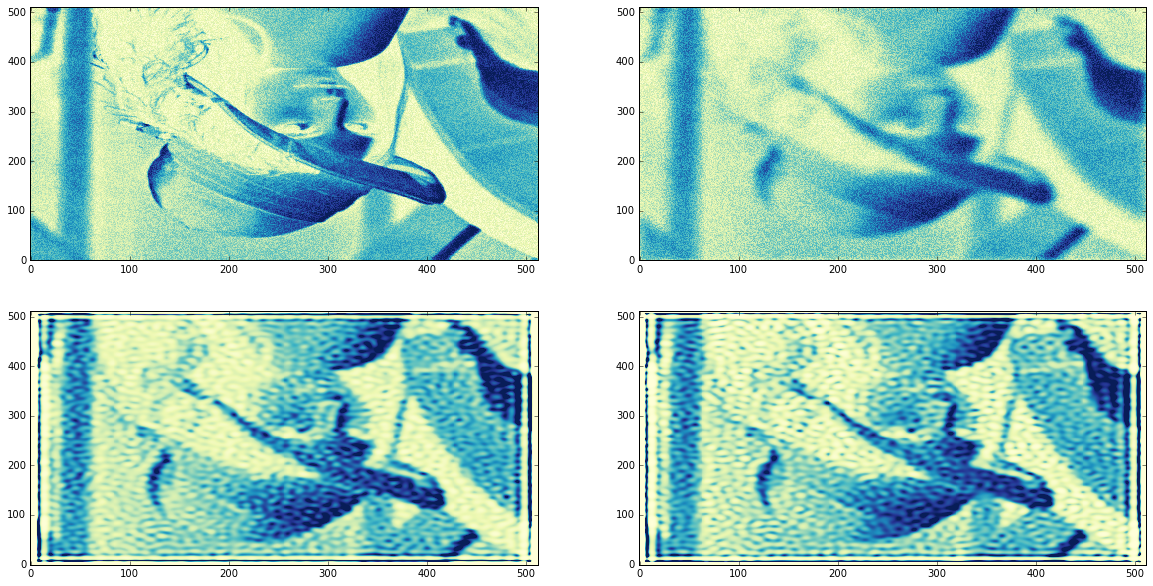

In [692]:
plt.figure(figsize=(20, 10))
plt.subplot(2, 2, 1)
plt.imshow(channel)
plt.clim(0, 255)

plt.subplot(2, 2, 2)
plt.imshow(blur_channel)
plt.clim(0, 255)

plt.subplot(2, 2, 3)
plt.imshow(new_im)
plt.clim(0, 255)

plt.subplot(2, 2, 4)
plt.imshow(sk_im)
plt.clim(0, 255)

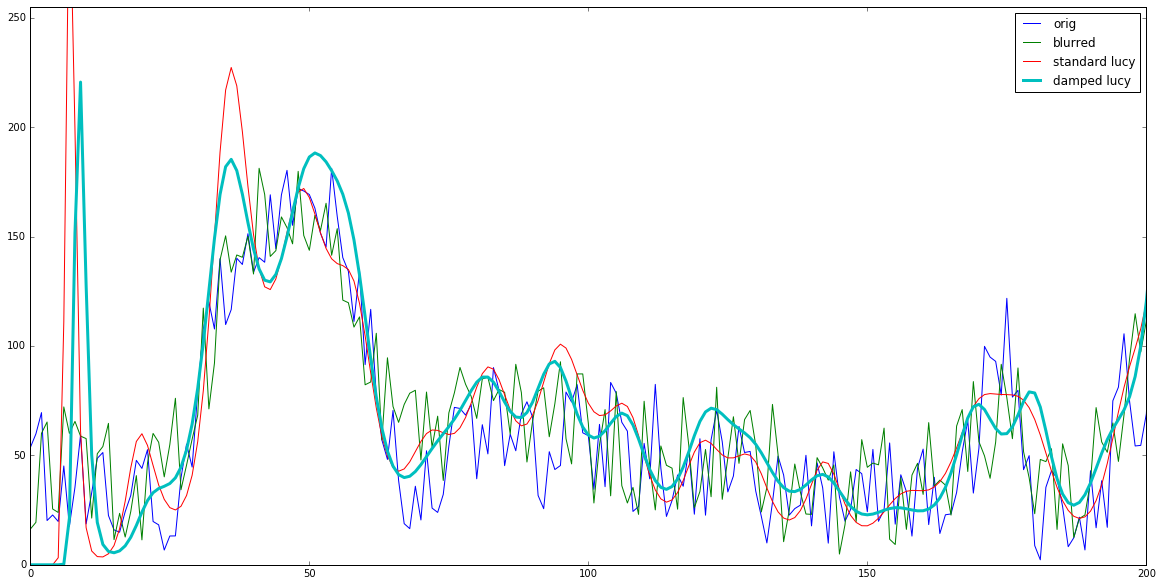

In [693]:
plt.figure(figsize=(20, 10))
plt.plot(channel[300], label='orig')
plt.plot(blur_channel[300], label='blurred')
plt.plot(sk_im[300], label='standard lucy')
plt.plot(new_im[300], label='damped lucy', lw=3)
plt.ylim(0, 255)
plt.xlim(0, 200)
plt.legend()

Traceback (most recent call last):
  File "/Users/ely/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2885, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-695-45077e88845d>", line 1, in <module>
    get_ipython().magic('cd ')
  File "/Users/ely/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2163, in magic
    return self.run_line_magic(magic_name, magic_arg_s)
  File "/Users/ely/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2084, in run_line_magic
    result = fn(*args,**kwargs)
  File "<decorator-gen-92>", line 2, in cd
  File "/Users/ely/anaconda3/lib/python3.5/site-packages/IPython/core/magic.py", line 193, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/Users/ely/anaconda3/lib/python3.5/site-packages/IPython/core/magics/osm.py", line 289, in cd
    oldcwd = py3compat.getcwd()
FileNotFoundError: [Errno 2] No such file or directory

Duri

ERROR: Internal Python error in the inspect module.
Below is the traceback from this internal error.


Unfortunately, your original traceback can not be constructed.



FileNotFoundError: [Errno 2] No such file or directory